In [1]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return the number of GPUs
print(torch.cuda.get_device_name(0))  # Should show the GPU model

True
1
NVIDIA GB10


/home/spark/anaconda3/envs/lmforge/lib/python3.10/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


In [2]:
import transformers
import torch
import os
import json
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM
import logging
import time
from datetime import timedelta, datetime
import pandas as pd
from dotenv import load_dotenv
import shutil 

import evaluate
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Load environment variables
load_dotenv(dotenv_path="../../.env") # path is relative to this script, adjust as needed

run_id = "LMForge_RUN06_DGX_SPARK_Qwen2.5-7B-Instruct"  # <- Change this manually for each experiment
batch_size = 10  # <- Change this manually for each experiment

In [3]:
from transformers.utils import LossKwargs


In [4]:
import logging
logging.basicConfig(filename='generation.log', level=logging.INFO)
logging.info(f"Run ID: {run_id}")

In [ ]:
# setting huggingface token
login(token=os.getenv("#"))

# os.environ["HF_HOME"] = "D:/huggingface_cache" 
# os.environ["TRANSFORMERS_CACHE"] = "D:/huggingface_cache"
# os.environ["HUGGINGFACE_HUB_CACHE"] = "D:/huggingface_cache"

# print("HF_HOME:", os.getenv("HF_HOME"))
# print("TRANSFORMERS_CACHE:", os.getenv("TRANSFORMERS_CACHE"))
# print("HUGGINGFACE_HUB_CACHE:", os.getenv("HUGGINGFACE_HUB_CACHE"))

# logging.info(f"HF_HOME: {os.getenv('HF_HOME')}")
# logging.info(f"TRANSFORMERS_CACHE: {os.getenv('TRANSFORMERS_CACHE')}")
# logging.info(f"HUGGINGFACE_HUB_CACHE: {os.getenv('HUGGINGFACE_HUB_CACHE')}")

# transformers.utils.hub.TRANSFORMERS_CACHE = "D:/huggingface_cache"

In [6]:
model_name = "Qwen/Qwen2.5-7B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="cuda", trust_remote_code=True)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
chunk_sizes = [128, 256, 512, 1024]
questions_num = 2
max_token_list = [128,256,512,1024,2048]


In [8]:
results_df = pd.DataFrame(columns=[
    "chunk_size", "questions_num", "qa_count_mismatch", "total_questions", "token_Size",
    "total_chunks", "success_count", "fail_count",
    "elapsed_time"
])

In [9]:
def power_analysis(chunk_size, max_tokens, qa_results,substring_date,elapsed_time):
    """
    Perform power analysis based on the provided parameters for the current run.
    """
    
    # https://huggingface.co/spaces/evaluate-metric/bertscore
    # https://huggingface.co/tasks/sentence-similarity
    # 1 Metric: ROUGE
    rouge = evaluate.load("rouge")

    originals = []
    generations = []

    for doc in qa_results.values():
        for item in doc:
            chunk = item.get("chunk")
            qa_pairs = item.get("qa_pairs", [])
            if not chunk or not isinstance(qa_pairs, list):
                continue  # Skip if chunk is missing or qa_pairs is not a list
            for pair in qa_pairs:
                answer = pair.get("answer") if isinstance(pair, dict) else None
                if answer:  # Only add if answer exists and is not None/empty
                    originals.append(str(chunk))
                    generations.append(str(answer))


    scores = rouge.compute(predictions=generations, references=originals)
    print(f"ROUGE Scores: {scores}")
    logging.info(f"ROUGE Scores: {scores} for chunk_size {chunk_size}, max_tokens {max_tokens}, questions_num {questions_num}")

    # 2 Metric: BERTScore
    bertscore = evaluate.load("bertscore")
    bert_scores = bertscore.compute(predictions=generations, references=originals, model_type="bert-base-uncased", lang="en")
    P = bert_scores["precision"]
    R = bert_scores["recall"]
    F1 = bert_scores["f1"] 

    print(f"BERTScore: {bert_scores}")
    logging.info(f"BERTScore: {bert_scores} for chunk_size {chunk_size}, max_tokens {max_tokens}, questions_num {questions_num}")

    # 3 Metric: STS (Semantic Textual Similarity)
    sts_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    original_embeddings = sts_model.encode(originals, convert_to_tensor=True) 
    generated_embeddings = sts_model.encode(generations, convert_to_tensor=True)
    sts_scores = util.pytorch_cos_sim(original_embeddings, generated_embeddings).diagonal().cpu().tolist()

    print(f"STS Scores: {sts_scores}")
    logging.info(f"STS Scores: {sts_scores} for chunk_size {chunk_size}, max_tokens {max_tokens}, questions_num {questions_num}")

    # save the scores to a CSV file
    scores_df = pd.DataFrame({
        "chunk_size": [chunk_size],
        "max_tokens": [max_tokens],
        "questions_num": [questions_num],
        "rouge1": [scores["rouge1"]],
        "rouge2": [scores["rouge2"]],
        "rougeL": [scores["rougeL"]],
        "rougeLsum": [scores["rougeLsum"]],
        "bert_score_P": [np.mean(P)],
        "bert_score_R": [np.mean(R)],
        "bert_score_F1": [np.mean(F1)],
        "sts_score": [np.mean(sts_scores)],
        "substring_date": [substring_date],
        "elapsed_time": [elapsed_time],
    })
    
    print("Scores saved to scores.csv")   
    logging.info(f"Scores saved to scores.csv for chunk_size {chunk_size}, max_tokens {max_tokens}, questions_num {questions_num}")
    return scores_df

# Convert logs to Panda


In [10]:
def build_prompt(chunk, questions_num):
    return f"""
Generate {questions_num} question-answer pairs based on the following text segment. 
Return the result in valid JSON format as a list of objects.

Text Segment:

{chunk}

Response Format:
[
    {{"question": "generated question", "answer": "generated Answer"}},
]

Question answers should be at least 250 words long.

Do NOT include any explanation or preamble before or after the JSON output.
Return ONLY valid JSON output.

Answer:
    """

In [11]:
def load_data(chunk_size):
    path = f"../Spring25/Generate_Paragraphs/Results/extracted_chunks_{chunk_size}_overlap.json"
    if not os.path.exists(path):
        print(f"Missing input file: {path}, skipping.")
        logging.info(f"Missing input file: {path}, skipping.")
        return None
    with open(path, "r", encoding="utf-8") as file:
        return json.load(file)

In [12]:
def update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, key, value):
    if os.path.exists(detailed_tracker_path):
        detailed_tracker_df = pd.read_csv(detailed_tracker_path)
    else:
        detailed_tracker_df = pd.DataFrame(columns=["chunk_size", "questions_num", "qa_count_mismatch", "total_questions", 
            "max_tokens", "total_chunks", "success_count", "fail_count", "repeat_count", "duplicate_count", "elapsed_time"])
    # Check if the row already exists
    row_match = (
        (detailed_tracker_df["chunk_size"] == chunk_size) &
        (detailed_tracker_df["max_tokens"] == max_tokens) 
    )
    if not detailed_tracker_df.loc[row_match].empty:
        # Update the existing row
        detailed_tracker_df.loc[row_match, key] = value
    else:
        # Add a new row
        new_row = {
            "chunk_size": chunk_size,
            "max_tokens": max_tokens,
            "questions_num": 0,
            "qa_count_mismatch": 0,
            "total_questions": 0,
            "total_chunks": 0,
            "success_count": 0,
            "fail_count": 0,
            "repeat_count": 0,
            "duplicate_count": 0,
            "elapsed_time": 0
        }
        new_row[key] = value
        # Append the new row to the DataFrame
        detailed_tracker_df = pd.concat([detailed_tracker_df, pd.DataFrame([new_row])], ignore_index=True)
        
    # Save the updated DataFrame to CSV
    detailed_tracker_df.to_csv(detailed_tracker_path, index=False)
    print(f"Updated detailed tracker: {detailed_tracker_path}")
    logging.info(f"Updated detailed tracker: {detailed_tracker_path}")

In [ ]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# check if base directory exists, if not create it
if not os.path.exists(run_id):
    os.makedirs(run_id)
# Constants
check_point_path = f"{run_id}/qa_run_tracker.csv"
output_base = f"{run_id}/Generated_Results/Qwen2.5-7B-Instruct-spark"
detailed_tracker_path = f"{run_id}/qa_run_tracker_detailed.csv"

# Initialize tracker CSV if not present
if not os.path.exists(check_point_path):
    tracker_df = pd.DataFrame(columns=["chunk_size", "max_tokens", "questions_num", "completed"])
    for chunk_size in chunk_sizes:
        for max_tokens in max_token_list:
            tracker_df.loc[len(tracker_df)] = [chunk_size, max_tokens, questions_num, False]
    tracker_df.to_csv(check_point_path, index=False)
else:
    tracker_df = pd.read_csv(check_point_path)
    

# Results summary
results_df = pd.DataFrame(columns=[
    "chunk_size", "questions_num", "qa_count_mismatch", "total_questions",
    "max_tokens", "total_chunks", "success_count", "fail_count", "repeat_count",
    "duplicate_count", "elapsed_time"
])

# Check if detailed tracker exists, if not create it
if not os.path.exists(detailed_tracker_path):
    detailed_tracker_df = pd.DataFrame(columns=["chunk_size", "questions_num", "qa_count_mismatch", "total_questions", 
        "max_tokens", "total_chunks", "success_count", "fail_count", "repeat_count", "duplicate_count", "elapsed_time"])
    detailed_tracker_df.to_csv(detailed_tracker_path, index=False)
else:
    detailed_tracker_df = pd.read_csv(detailed_tracker_path)

for chunk_size in chunk_sizes:
    chunk_data = load_data(chunk_size)

    for max_tokens in max_token_list:
        row_match = (
            
            (tracker_df["chunk_size"] == chunk_size) &
            (tracker_df["max_tokens"] == max_tokens) &
            (tracker_df["questions_num"] == questions_num)
        )

        if tracker_df.loc[row_match, "completed"].any():
            print(f"Skipping chunk_size={chunk_size}, max_tokens={max_tokens} (already completed)")
            logging.info(f"Skipping chunk_size={chunk_size}, max_tokens={max_tokens} (already completed)")
            continue
        print(f"Processing chunk_size={chunk_size}, max_tokens={max_tokens}")
        logging.info(f"Processing chunk_size={chunk_size}, max_tokens={max_tokens}")

        output_file_path = f"{output_base}/generation_log_{chunk_size}_Token_{max_tokens}_Q{questions_num}.json"

        # Load existing results if file exists
        if os.path.exists(output_file_path):
            try:
                with open(output_file_path, "r", encoding="utf-8") as f:
                    qa_results = json.load(f)
            except json.JSONDecodeError:
                print("Warning: Output file is corrupted. Starting fresh.")
                logging.info("Warning: Output file is corrupted. Starting fresh.")
                qa_results = {}
        else:
            # Create the output directory if it doesn't exist
            os.makedirs(os.path.dirname(output_file_path), exist_ok=True)
            qa_results = {}

        # Trackers
        total_chunks = 0
        success_count = 0
        fail_count = 0
        total_questions = 0
        qa_count_mismatch = 0
        repeat_count = 0
        duplicate_count = 0
        chunk_counter = 0

        start_time = time.time()

        for doc_name, chunks in chunk_data.items():
            if doc_name in qa_results and qa_results[doc_name]:
                print(f"Skipping {doc_name} (already processed)")
                logging.info(f"Skipping {doc_name} (already processed)")
                continue
            print(f"Processing {doc_name}...")
            logging.info(f"Processing {doc_name}...")
            # Initialize the document in the results dictionary
            qa_results[doc_name] = []

            for chunk in chunks[:900]:  # Adjust slice as needed
                total_chunks += 1
                update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "total_chunks", total_chunks)
                chunk_counter += 1
                prompt = build_prompt(chunk, questions_num)
                try:
                    inputs = tokenizer(prompt, return_tensors="pt").to(device)
                    with torch.no_grad():
                        output_tokens = model.generate(**inputs, max_new_tokens=max_tokens,pad_token_id=tokenizer.eos_token_id)
                    generated_tokens = output_tokens[0][len(inputs["input_ids"][0]):]
                    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
                    print(generated_text)
                    qa_pairs = json.loads(generated_text)

                    if isinstance(qa_pairs, list):
                        qa_results[doc_name].append({
                            "chunk": chunk,
                            "qa_pairs": qa_pairs
                        })
                        success_count += 1
                        update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "success_count", success_count)
                        total_questions += len(qa_pairs)
                        update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "total_questions", total_questions)

                        if len(qa_pairs) != questions_num:
                            qa_count_mismatch += 1
                            update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "qa_count_mismatch", qa_count_mismatch)
                            logging.info(f"Warning: Expected {questions_num} questions, got {len(qa_pairs)}")
                        
                        #  question and answer are the same
                        for pair in qa_pairs:
                            if pair["question"] == pair["answer"]:
                                repeat_count += 1
                                update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "repeat_count", repeat_count)
                                logging.info(f"Warning: Question and answer are the same in {doc_name}")
                            # check for duplicates in the same chunk
                            if any(pair["question"] == p["question"] for p in qa_pairs if p != pair):
                                duplicate_count += 1
                                update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "duplicate_count", duplicate_count)
                                logging.info(f"Warning: Duplicate question in {doc_name}")
                    else:
                        fail_count += 1
                        update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "fail_count", fail_count)
                        logging.info(f"Warning: Invalid JSON format in {doc_name}: {generated_text}")

                except Exception as e:
                    print(f"Error processing chunk from {doc_name}: {e}")
                    logging.error(f"Error processing chunk from {doc_name}: {e}")
                    fail_count += 1
                    update_detailed_tracker(detailed_tracker_path,chunk_size, max_tokens, "fail_count", fail_count)
                    continue

                # Save every batch_size chunks
                if chunk_counter % batch_size == 0:
                    with open(output_file_path, "w", encoding="utf-8") as out_file:
                        json.dump(qa_results, out_file, indent=4, ensure_ascii=False)
                    print(f"Checkpoint saved at chunk {chunk_counter}")
                    logging.info(f"Checkpoint saved at chunk {chunk_counter}")

                    # update the detailed tracker
                    

            # Save after each document
            with open(output_file_path, "w", encoding="utf-8") as out_file:
                json.dump(qa_results, out_file, indent=4, ensure_ascii=False)
            print(f"Saved full doc: {doc_name}")
            logging.info(f"Saved full doc: {doc_name}")

        # Final save
        end_time = time.time()
        elapsed_time = timedelta(seconds=end_time - start_time)

        results_df.loc[len(results_df)] = [
            chunk_size, questions_num, qa_count_mismatch, total_questions,
            max_tokens, total_chunks, success_count, fail_count, repeat_count,
            duplicate_count, str(elapsed_time)
        ]

        print(f"Completed {chunk_size}, {max_tokens} | Time: {elapsed_time}")
        logging.info(f"Completed {chunk_size}, {max_tokens} | Time: {elapsed_time}")

        # Update tracker
        tracker_df.loc[row_match, "completed"] = True
        tracker_df.to_csv(check_point_path, index=False)

        scores_df = power_analysis(chunk_size, max_tokens, qa_results,run_id,elapsed_time)
        if os.path.exists(f"{output_base}/scores.csv"):
            scores_df.to_csv(f"{output_base}/scores.csv", mode='a', header=False, index=False)
        else:
            os.makedirs(f"{output_base}/scores", exist_ok=True)
            scores_df.to_csv(f"{output_base}/scores.csv", index=False)
        # save the results to a CSV file
        if os.path.exists(f"{output_base}/qa_generation_results.csv"):
            results_df.to_csv(f"{output_base}/qa_generation_results.csv", mode='a', header=False, index=False)
        else:
            os.makedirs(f"{output_base}/qa_generation_results", exist_ok=True)
            results_df.to_csv(f"{output_base}/qa_generation_results.csv", index=False)
        print(f"Results saved to {output_base}/qa_generation_results.csv")
        logging.info(f"Results saved to {output_base}/qa_generation_results.csv")


# Save summary CSV
csv_output_path = f"{output_base}/qa_generation_results_summary.csv"
results_df.to_csv(csv_output_path, index=False)
print(f"\nSummary saved to {csv_output_path}")
logging.info(f"\nSummary saved to {csv_output_path}")


Skipping chunk_size=128, max_tokens=128 (already completed)
Processing chunk_size=128, max_tokens=256
Processing Documents/Legal Aspects of Corporate Management and Finance.pdf...
Updated detailed tracker: LMForge_RUN06_DGX_SPARK_Qwen2.5-7B-Instruct/qa_run_tracker_detailed.csv
 [{"question": "What type of license did The Saylor Foundation use for this textbook adaptation?", "answer": "The Saylor Foundation used a Creative Commons Attribution-NonCommercial-ShareAlike 3.0 License for adapting this textbook."}, 
      {"question": "How does the textbook relate to everyday life experiences of students according to the given text?", "answer": "The textbook relates to everyday life experiences of students by engaging them through the connection of law to everyday events with which they are familiar, as mentioned in the provided text."}]
Updated detailed tracker: LMForge_RUN06_DGX_SPARK_Qwen2.5-7B-Instruct/qa_run_tracker_detailed.csv
Updated detailed tracker: LMForge_RUN06_DGX_SPARK_Qwen2.5-7

In [ ]:
import shutil
import os
import json
import pandas as pd
def load_data(chunk_size):
    path = f"../Spring25/Generate_Paragraphs/Results/extracted_chunks_{chunk_size}_overlap.json"
    if not os.path.exists(path):
        print(f"Missing input file: {path}, skipping.")
        return None
    with open(path, "r", encoding="utf-8") as file:
        return json.load(file)
    

chunk_sizes = [128, 256, 512, 1024]
# check how many chunks are in the file for each chunk size

for chunk_size in chunk_sizes:
    chunk_data = load_data(chunk_size)
    if chunk_data is not None:
        total_chunks = sum(len(chunks) for chunks in chunk_data.values())
        print(f"Total chunks for chunk size {chunk_size}: {total_chunks}")
    else:
        print(f"No data found for chunk size {chunk_size}")

Total chunks for chunk size 128: 6996
Total chunks for chunk size 256: 3618
Total chunks for chunk size 512: 1824
Total chunks for chunk size 1024: 910


## Statistical Significance

#### MANOVA ASSUMPTIONS
- Multivariate Normality dependent variables should be jointly normally distributed
- Homogeneity of variance-covariance matrices
- Independence of observations
- No multicollinearity
- Linearity
- Outliers 

In [ ]:
from scipy.stats import chi2 , probplot
from sklearn.covariance import MinCovDet
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import os
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



# Load the CSV files
output_base = "LMForge_RUN02/Generated_Results/DeepSeek-R1-0528-Qwen3-8B"
if os.path.exists(f"{output_base}/scores.csv"):
    print(f"File {f"{output_base}/scores.csv"} exists.")
else:
    print(f"File {f"{output_base}/scores.csv"} does not exist. Please check the path.")
# Read the CSV file
scores_df = pd.read_csv(f"{output_base}/scores.csv")
# drop duplicates
scores_df = scores_df.drop_duplicates(subset=["chunk_size", "max_tokens"], keep="first").drop(columns=["elapsed_time","questions_num"])

dv_columns = [
    "rouge1", "rouge2", "rougeL", "rougeLsum",
    "bert_score_P", "bert_score_R", "bert_score_F1",
    "sts_score"
]

SyntaxError: f-string: expecting '}' (2016577866.py, line 24)

File LMForge_RUN02/Generated_Results/LLAMA3_1/scores.csv exists.


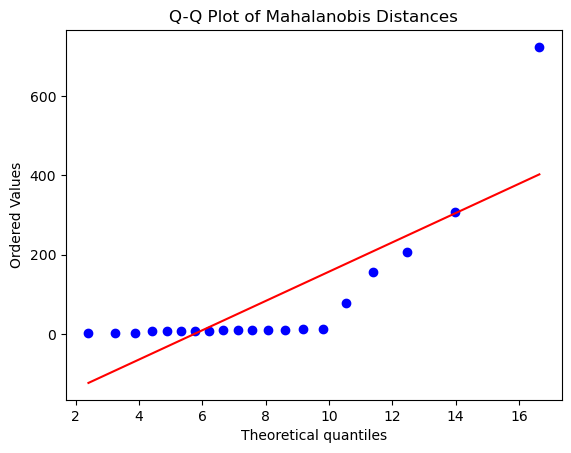

Henze-Zirkler Test:
 HZResults(hz=1.0795278119755913, pval=1.5825002782747915e-06, normal=False)


In [ ]:
# Select only the dependent variables (DVs)
X = scores_df[dv_columns].dropna()

# Compute robust Mahalanobis distances
robust_cov = MinCovDet().fit(X)
mahalanobis_distances = robust_cov.mahalanobis(X)

# Chi-squared Q-Q plot
probplot(mahalanobis_distances, dist="chi2", sparams=(len(dv_columns),), plot=plt)
plt.title("Q-Q Plot of Mahalanobis Distances")
plt.show()

# Formal multivariate normality test (Henze-Zirkler's)
normality_test = pg.multivariate_normality(scores_df[dv_columns], alpha=0.05)
print("Henze-Zirkler Test:\n", normality_test)


In [ ]:
# Calculate the threshold for outliers
threshold = chi2.ppf(0.99, df=len(dv_columns))
outliers = mahalanobis_distances > threshold
# Print the number of outliers
print(f"Outlier count: {np.sum(outliers)}")
# identifying the outliers
outlier_indices = np.where(outliers)[0]
outlier_rows = scores_df.iloc[outlier_indices]
print("Outlier rows:")
print(outlier_rows)


Outlier count: 5
Outlier rows:
    chunk_size  max_tokens    rouge1    rouge2    rougeL  rougeLsum  \
0          128         128  0.240665  0.171811  0.209919   0.229688   
3          128        1024  0.351167  0.231052  0.284325   0.332217   
4          128        2048  0.347461  0.221321  0.275704   0.326842   
15        1024         128  0.031999  0.021180  0.028436   0.031318   
17        1024         512  0.081810  0.059997  0.070784   0.080223   

    bert_score_P  bert_score_R  bert_score_F1  sts_score substring_date  
0       0.714532      0.440610       0.539756   0.559266  LMForge_RUN02  
3       0.691136      0.520246       0.585593   0.609433  LMForge_RUN02  
4       0.679636      0.520178       0.581982   0.618118  LMForge_RUN02  
15      0.593533      0.313629       0.406797   0.360901  LMForge_RUN02  
17      0.637666      0.376273       0.467231   0.447940  LMForge_RUN02  


In [ ]:
## homogeneity of covariance matrices 
# Box's M test
scores_df["group"] = scores_df["chunk_size"].astype(str)

# Then re-clean and re-test
df_clean = scores_df.dropna(subset=dv_columns + ["group"])
box_m = pg.box_m(data=df_clean, dvs=dv_columns, group='group')
print("Box’s M Test:\n", box_m)

Box’s M Test:
      Chi2     df  pval  equal_cov
box   inf  108.0   0.0      False


/opt/anaconda3/lib/python3.12/site-packages/pingouin/multivariate.py:386: RuntimeWarning: divide by zero encountered in log
  u = -2 * (1 - c) * np.log(M)


In [ ]:
threshold = chi2.ppf(0.999, df=X.shape[1])  # 99.9% cutoff
outlier_flags = mahalanobis_distances > threshold
num_outliers = np.sum(outlier_flags)

# summary of outlier results
outlier_summary = pd.DataFrame([{
    "Total Observations": len(mahalanobis_distances),
    "Outliers Detected (p < 0.001)": num_outliers,
    "Percentage Outliers": 100 * num_outliers / len(mahalanobis_distances)
}])
print(outlier_summary)

   Total Observations  Outliers Detected (p < 0.001)  Percentage Outliers
0                  20                              5                 25.0


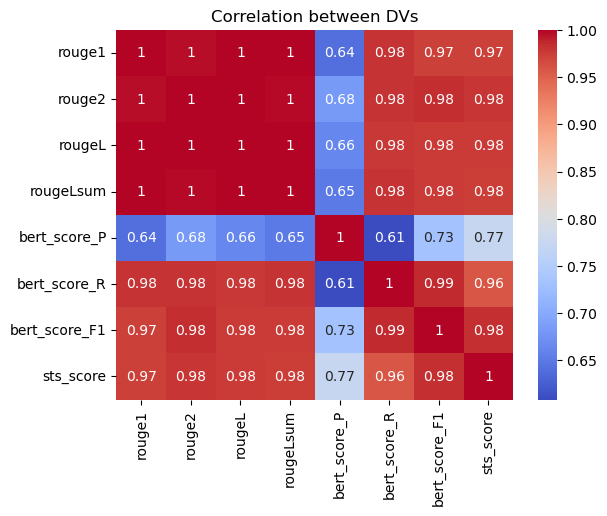

In [ ]:
# Check correlation between DVs
sns.heatmap(scores_df[dv_columns].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between DVs")
plt.show()


In [ ]:
# Check for multicollinearity

# Add a constant to the model
X_with_const = add_constant(X)
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print(vif_data)

         feature           VIF
0          const   8996.863254
1         rouge1  88353.609271
2         rouge2   4995.350022
3         rougeL  12965.565541
4      rougeLsum  62530.524231
5   bert_score_P    193.709623
6   bert_score_R   4317.033541
7  bert_score_F1   4684.069453
8      sts_score    193.722995


In [ ]:
# Define DVs
dv_columns = [
    "rouge1", "rouge2", "rougeL", "rougeLsum",
    "bert_score_P", "bert_score_R", "bert_score_F1", "sts_score"
]

# Create group variable
scores_df["group"] = scores_df["chunk_size"].astype(str)

# Drop missing
df_simple = scores_df.dropna(subset=dv_columns + ["group"])

# Create MANOVA formula
formula_simple = " + ".join(dv_columns) + " ~ group"

# Fit MANOVA
maov_simple = MANOVA.from_formula(formula_simple, data=df_simple)
print(maov_simple.mv_test())


                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept          Value   Num DF Den DF  F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda    0.0002 8.0000 9.0000 5157.1422 0.0000
         Pillai's trace    0.9998 8.0000 9.0000 5157.1422 0.0000
 Hotelling-Lawley trace 4584.1264 8.0000 9.0000 5157.1422 0.0000
    Roy's greatest root 4584.1264 8.0000 9.0000 5157.1422 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
         group           Value    Num DF  Den DF F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda   0.0000 24.0000 26.7040  44.8593 0.0000
         Pillai's trace   2.6072 24.0000 33.0

In [ ]:
# Type III ANOVA

# Fit the model using OLS
def type_3(formula, data):
    """
    Perform Type III ANOVA using the given formula and data.
    """
    model = ols(formula, data=data).fit()
    anova_results = anova_lm(model, typ=3)
    return anova_results

# Perform Type III ANOVA for each dependent variable
results = []
for column in dv_columns:
    formula = f"{column} ~ group"
    anova_results = type_3(formula, df_clean)
    print(f"ANOVA results for {column}:\n", anova_results)
    results.append((column, anova_results))

# results
anova_results_dict = {column: result for column, result in results}



ANOVA results for rouge1:
              sum_sq    df          F    PR(>F)
Intercept  0.029093   1.0  13.816819  0.001873
group      0.178835   3.0  28.310453  0.000001
Residual   0.033690  16.0        NaN       NaN
ANOVA results for rouge2:
              sum_sq    df          F    PR(>F)
Intercept  0.016336   1.0  16.238389  0.000970
group      0.072025   3.0  23.865055  0.000004
Residual   0.016096  16.0        NaN       NaN
ANOVA results for rougeL:
              sum_sq    df          F        PR(>F)
Intercept  0.022291   1.0  17.462634  7.092123e-04
group      0.113757   3.0  29.704922  8.945681e-07
Residual   0.020424  16.0        NaN           NaN
ANOVA results for rougeLsum:
              sum_sq    df          F    PR(>F)
Intercept  0.028120   1.0  14.524290  0.001536
group      0.156535   3.0  26.950182  0.000002
Residual   0.030978  16.0        NaN       NaN
ANOVA results for bert_score_P:
              sum_sq    df            F        PR(>F)
Intercept  2.036713   1.0  6344.848

In [ ]:
scores_df["group"] = scores_df["chunk_size"].astype(str)
df_simple = scores_df.dropna(subset=dv_columns + ["group"])

# Create distance matrix and group labels reference: https://scikit.bio/docs/dev/generated/skbio.stats.distance.html
X = df_simple[dv_columns].values
group_labels = df_simple["group"].values
distance_matrix = DistanceMatrix(squareform(pdist(X, metric='euclidean')))

# Run PERMANOVA
results = permanova(distance_matrix, grouping=group_labels, permutations=999)
print("PERMANOVA results for chunk_size groups:")
print(results)



scores_df["group2"] = scores_df[["max_tokens"]].astype(str)
# Create distance matrix and group labels
X2 = scores_df[dv_columns].values
distance_matrix2 = DistanceMatrix(squareform(pdist(X2, metric='euclidean')))
# Run PERMANOVA for the second group
results2 = permanova(distance_matrix2, grouping=scores_df["group2"].values, permutations=999)
print("PERMANOVA results for max_tokens groups:")
print(results2)



PERMANOVA results for chunk_size groups:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      20
number of groups                  4
test statistic            23.744764
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object
PERMANOVA results for max_tokens groups:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      20
number of groups                  5
test statistic             0.736644
p-value                       0.565
number of permutations          999
Name: PERMANOVA results, dtype: object


MANOVA results on PCA components:
                  Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.2891 2.0000 15.0000 18.4387 0.0001
         Pillai's trace 0.7109 2.0000 15.0000 18.4387 0.0001
 Hotelling-Lawley trace 2.4585 2.0000 15.0000 18.4387 0.0001
    Roy's greatest root 2.4585 2.0000 15.0000 18.4387 0.0001
------------------------------------------------------------
                                                            
------------------------------------------------------------
         group          Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.0639 6.0000 30.0000 14.7822 0.0000
         Pillai's trace 1.4756 6.0000 32.0000 15.0083 0.0000
 Hotell

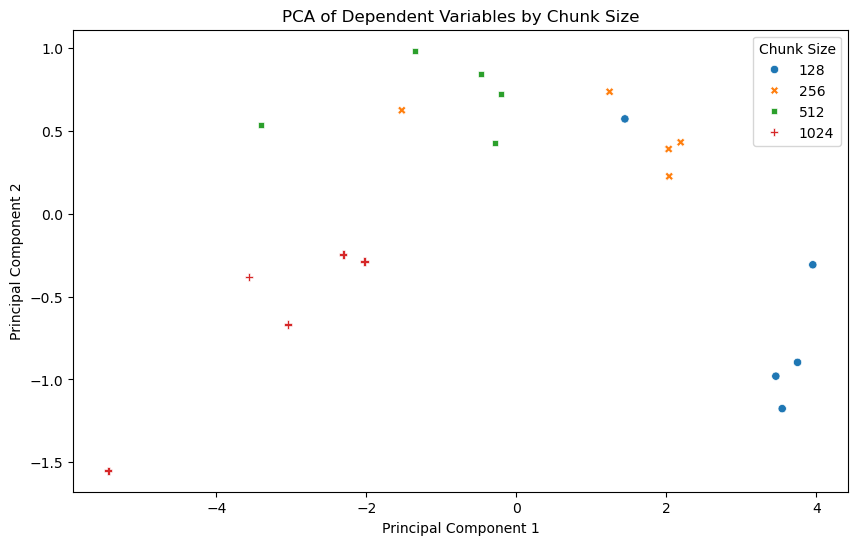

In [ ]:
# PCA + MANOVA 
scores_df["group"] = scores_df["chunk_size"].astype(str)
df_clean = scores_df.dropna(subset=dv_columns + ["group"])

# Standardize the dependent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[dv_columns])

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add principal components to the dataframe
df_clean["PC1"] = X_pca[:, 0]
df_clean["PC2"] = X_pca[:, 1]

# Run MANOVA on the first two principal components
from statsmodels.multivariate.manova import MANOVA
maov_pca = MANOVA.from_formula("PC1 + PC2 ~ group", data=df_clean)
manova_pca_results = maov_pca.mv_test()
print("MANOVA results on PCA components:\n", manova_pca_results)
# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x="PC1", y="PC2", hue="group", style="group")
plt.title("PCA of Dependent Variables by Chunk Size")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Chunk Size")
plt.show()

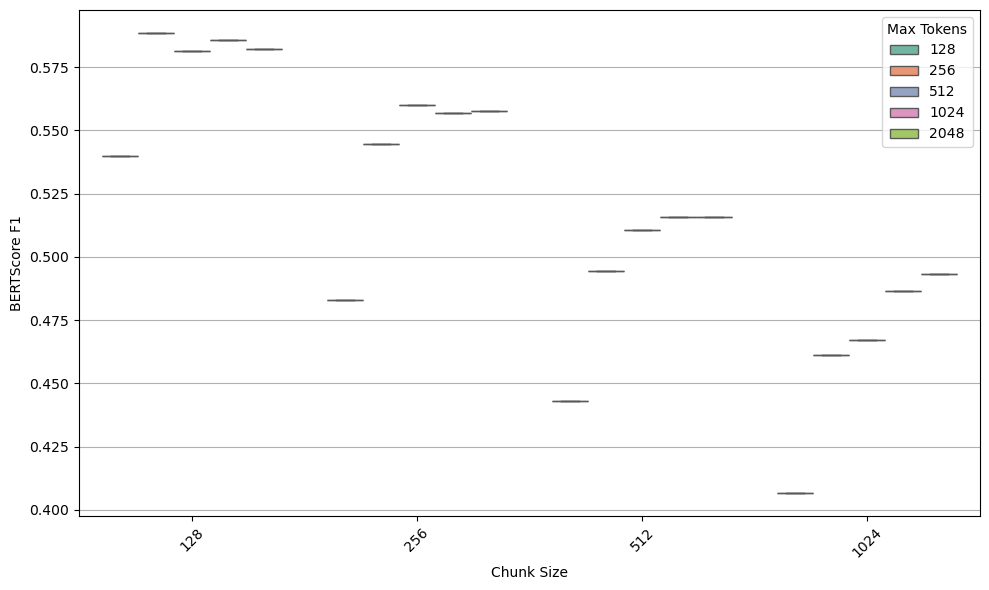

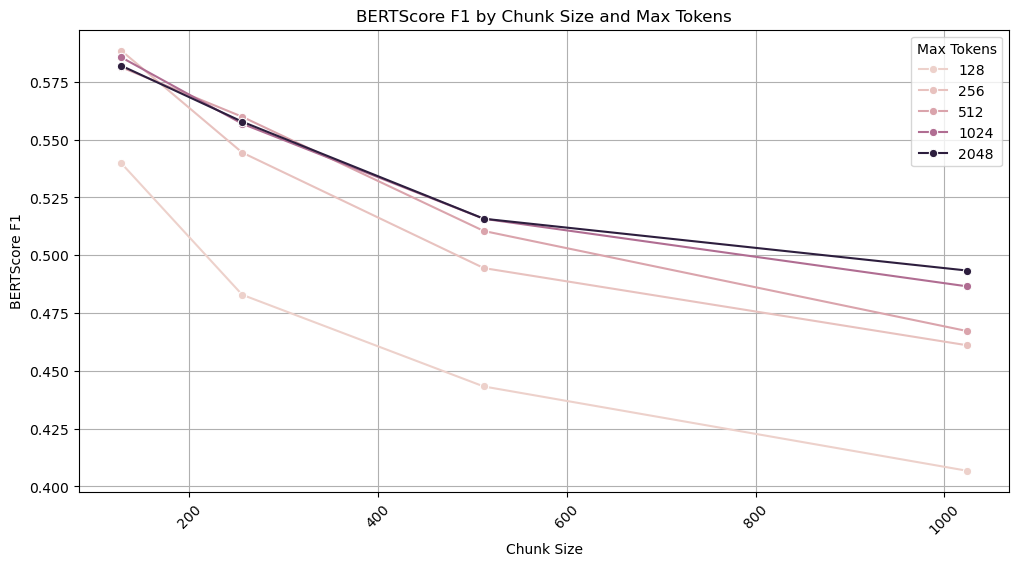

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='chunk_size', y='bert_score_F1', hue='max_tokens', data=scores_df, palette="Set2")
plt.xlabel("Chunk Size")
plt.ylabel("BERTScore F1")
plt.xticks(rotation=45)
plt.legend(title="Max Tokens")
plt.grid(axis='y')
plt.tight_layout()
plt.figure(figsize=(12, 6))
sns.lineplot(data=scores_df, x='chunk_size', y='bert_score_F1', hue='max_tokens', marker='o')
plt.xlabel("Chunk Size")
plt.ylabel("BERTScore F1")
plt.title("BERTScore F1 by Chunk Size and Max Tokens")
plt.xticks(rotation=45)
plt.legend(title="Max Tokens")
plt.grid()

In [ ]:
from itertools import combinations
from scipy.spatial.distance import pdist, squareform

pairwise_results = []
scores_df["group"] = scores_df["chunk_size"].astype(str)

# Looping through the combinations of groups
for grp1, grp2 in combinations(scores_df["group"].unique(), 2):
    subset = scores_df[scores_df["group"].isin([grp1, grp2])].copy()
    subset = subset.reset_index(drop=True)
    
    # Distance matrix
    X_pair = subset[dv_columns].values
    distance_array = squareform(pdist(X_pair, metric='euclidean'))
    ids = [str(i) for i in subset.index]
    distance_matrix = DistanceMatrix(distance_array, ids=ids)
    
    # DataFrame with group labels
    grouping_df = pd.DataFrame({'group': subset["group"].values}, index=ids)
    
    # PERMANOVA 
    result = permanova(distance_matrix, grouping=grouping_df, column='group', permutations=999)
    
    pairwise_results.append({
        "Group 1": grp1,
        "Group 2": grp2,
        "Pseudo-F": result["test statistic"],
        "p-value": result["p-value"]
    })

pairwise_df = pd.DataFrame(pairwise_results)
print(pairwise_df)


  Group 1 Group 2   Pseudo-F  p-value
0     128     256   7.242994    0.029
1     128     512  36.159047    0.007
2     128    1024  75.109721    0.009
3     256     512   7.081500    0.030
4     256    1024  23.854621    0.010
5     512    1024   6.190598    0.035


In [ ]:
# Compute group means
group_means = scores_df.groupby('chunk_size')[dv_columns].mean().mean(axis=1).sort_index()
print("Group Means:")
print(group_means)

differences = []
# Calculate differences between each pair of groups
for (grp1, grp2) in combinations(group_means.index, 2):
    diff = group_means[grp2] - group_means[grp1]
    differences.append({
        "Group 1": grp1,
        "Group 2": grp2,
        "Mean Difference": diff
    })

differences_df = pd.DataFrame(differences)
print("Mean Differences between Groups:")
print(differences_df)


Group Means:
chunk_size
128     0.436578
256     0.381648
512     0.321881
1024    0.271981
dtype: float64
Mean Differences between Groups:
   Group 1  Group 2  Mean Difference
0      128      256        -0.054930
1      128      512        -0.114697
2      128     1024        -0.164598
3      256      512        -0.059767
4      256     1024        -0.109668
5      512     1024        -0.049901


In [ ]:
# Step 1: Compute group means per DV
group_means = scores_df.groupby('chunk_size')[dv_columns].mean().sort_index()
print("Group Means:")
print(group_means)

# Step 2: Compute pairwise mean differences for each DV
differences = []
chunk_sizes = group_means.index.tolist()

for dv in dv_columns:
    for grp1, grp2 in combinations(chunk_sizes, 2):
        diff = group_means.loc[grp2, dv] - group_means.loc[grp1, dv]
        differences.append({
            "Dependent Variable": dv,
            "Group 1": grp1,
            "Group 2": grp2,
            "Mean Difference": diff
        })

# Step 3: Convert to DataFrame
differences_df = pd.DataFrame(differences)
print("Mean Differences between Groups for Each DV:")
print(differences_df)

Group Means:
              rouge1    rouge2    rougeL  rougeLsum  bert_score_P  \
chunk_size                                                          
128         0.325832  0.216365  0.266557   0.308374      0.696190   
256         0.231468  0.158992  0.191592   0.223323      0.709704   
512         0.138051  0.100932  0.118642   0.134836      0.695675   
1024        0.076280  0.057159  0.066770   0.074994      0.638234   

            bert_score_R  bert_score_F1  sts_score  
chunk_size                                          
128             0.501457       0.575429   0.602425  
256             0.445231       0.540396   0.552478  
512             0.392216       0.495966   0.498733  
1024            0.370272       0.463017   0.429117  
Mean Differences between Groups for Each DV:
   Dependent Variable  Group 1  Group 2  Mean Difference
0              rouge1      128      256        -0.094364
1              rouge1      128      512        -0.187781
2              rouge1      128     102

In [ ]:
from scipy.stats import ttest_ind
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Pairwise t-tests for each dependent variable
results = []
for dv in dv_columns:
    for grp1, grp2 in combinations(scores_df["chunk_size"].unique(), 2):
        vals1 = scores_df[scores_df["chunk_size"] == grp1][dv]
        vals2 = scores_df[scores_df["chunk_size"] == grp2][dv]
        t_stat, p_val = ttest_ind(vals1, vals2, equal_var=False)
        results.append({
            "Outcome": dv,
            "Group 1": grp1,
            "Group 2": grp2,
            "t-statistic": t_stat,
            "raw p-value": p_val
        })

ttest_df = pd.DataFrame(results)

# Applying the FDR (Benjamini-Hochberg) correction
reject, fdr_pvals, sidak_thresh, bonf_thresh = multipletests(ttest_df["raw p-value"], method='fdr_bh')
ttest_df["FDR (BH) p-value"] = fdr_pvals
ttest_df["Significant (FDR < 0.05)"] = reject

# results
print(ttest_df.head())
ttest_df.to_csv("pairwise_ttests_fdr.csv", index=False)


  Outcome  Group 1  Group 2  t-statistic  raw p-value  FDR (BH) p-value  \
0  rouge1      128      256     2.851769     0.022036          0.037495   
1  rouge1      128      512     6.401473     0.000212          0.001272   
2  rouge1      128     1024     9.856474     0.000029          0.000346   
3  rouge1      256      512     2.891892     0.021223          0.037495   
4  rouge1      256     1024     5.406126     0.001538          0.004407   

   Significant (FDR < 0.05)  
0                      True  
1                      True  
2                      True  
3                      True  
4                      True  
